In [2]:
!pip install portalocker
import portalocker
import torch
import torch.nn as nn
from torch.nn import functional as F
import math


In [3]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

## get data

In [ ]:
ger_train_path = "/home/adam/play/translate_data/train.de"
eng_train_path = "/home/adam/play/translate_data/train.en"

ger_train_raw = open(ger_train_path, "r").readlines()
eng_train_raw = open(eng_train_path, "r").readlines()

# just to help my poor laptop
ger_train_raw = ger_train_raw[:10000]
eng_train_raw = eng_train_raw[:10000]

FileNotFoundError: ignored

In [ ]:
print(len(ger_train))
print(len(eng_train))

10000
10000


In [ ]:
### tokenize
tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]) # do i need to account for the weird #AT things??
tokenizer.train(files=[ger_train_path, eng_train_path,], trainer=trainer)
tokenizer.enable_padding()
# tokenizer.train_from_iterator(iter(ger_train + eng_train), trainer=trainer)


In [ ]:
ger_train = tokenizer.encode_batch(ger_train_raw)
eng_train = tokenizer.encode_batch(eng_train_raw)

In [ ]:
ger_train = torch.tensor([t.ids for t in ger_train])
eng_train = torch.tensor([t.ids for t in eng_train])

In [ ]:
PAD_IDX

1

## define model

In [4]:
def create_mask(src, targ, pad_token):
    # NOTE: not fully confident in the unsqueeze - i think we get the extra-dimension so the masked_fill can broadcast it
    # we want to broadcast for the padding mask because it's the same on both axes (unlike with the causal mask)
    src_pad_mask = (src != pad_token).unsqueeze(1).unsqueeze(1) # (B, 1, 1, context_size)
    full_mask = torch.ones((targ.shape[1], targ.shape[1])).type(torch.int).unsqueeze(0).unsqueeze(0) # (1, 1, targ.shape[-1], targ.shape[-1])
    causal_atten_mask = torch.tril(full_mask) # (1, 1, context_size, context_size)
    targ_pad_mask = (targ != pad_token).unsqueeze(1).unsqueeze(1)

    return src_pad_mask, targ_pad_mask & causal_atten_mask

def calculate_loss(logits, labels, pad_idx):
    B, T, V = logits.shape # (batch, context_size, vocab_size)
    # cross entropy expects list of indices and logits requiring reshape

    out =  F.cross_entropy(logits.reshape(B * T, V), labels.reshape(B * T), ignore_index=pad_idx)
    return out

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.n_embed = n_embed
        self.n_heads = n_heads
        assert(n_embed % n_heads == 0) # check dims work
        self.head_size = n_embed // n_heads
        self.dropout = dropout

        self.wk = nn.Linear(n_embed, n_embed, bias=True)
        self.wq = nn.Linear(n_embed, n_embed, bias=True)
        self.wv = nn.Linear(n_embed, n_embed, bias=True)
        self.proj = nn.Linear(n_embed, n_embed)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, features, mask):
        B, T, C = features.shape # (batch, context_size, n_embed)

        # create k
        # NOTE: make sure the maths works here
        k = self.wk(features) # (B, context_size, n_embed) @ (n_embed, n_embed) ---> (B, context_size, n_embed)
        # split per head
        k = k.view(B, T, self.n_heads, self.head_size)  # (B, context_size, n_embed) --> (B, context_size, n_heads, head_size)
        # switch context size and n_heads dim so we can batch matmul over B and n_heads
        k = k.transpose(1,2) # (B, context_size, n_heads, head_size) --> (B, n_heads, context_size, head_size)

        # create q
        q = self.wq(x)
        q = q.view(q.shape[0], q.shape[1], self.n_heads, self.head_size) # q can be a different size to k and v so need to use its own .shape
        q = q.transpose(1,2)

        # create v
        v = self.wv(features)
        v = v.view(B, T, self.n_heads, self.head_size)
        v = v.transpose(1, 2)

        attn = q @ k.transpose(-2, -1) # (B, n_heads, context_size, head_size) @ (B, n_heads, head_size, context_size) --> (B, n_heads, context_size, context_size)
        attn = attn / (q.shape[-1] ** 0.5) # divide by squareroot of n_embed to decrease magnitude

        # if this is a masked attention layer (causal?) mask out all tokens before the cur pos, otherwise just mask out padding
        attn = attn.masked_fill(mask == 0, -1e10) # TODO: check that the dimensions here work
        attn = self.dropout(F.softmax(attn, dim=-1))
        self.store = attn

        # generate the v matrix and use the attn matrix to pluck out relevant info on a per head basis
        out = attn @ v # (B, n_heads, context_size, context_size) @ (B, n_heads, context_size, head_size) --> (B, n_heads, context_size, head_size)

        # remove per-head dimension and use final linear projection
        out = out.transpose(1,2).contiguous()
        out = out.view(out.shape[0], -1, self.n_embed) # (B, context_size , n_head, head_size) --> (B, context_size, n_embed)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed, ff_expansion_factor, dropout):
        super().__init__()
        self.ffw = nn.Sequential(
            nn.Linear(n_embed, ff_expansion_factor* n_embed),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_expansion_factor*n_embed, n_embed),
        )

    def forward(self, x):
        return self.ffw(x) # (B, context_size, n_embed) @ (n_embed, ff_expansion_factor*n_embed) @ (ff_expansion_factor*n_embed, n_embed) --> (B, context_size, n_embed)

class EncoderBlock(nn.Module):
    def __init__(self, n_heads, n_embed, ff_expansion_factor, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.ffw = FeedForward(n_embed, ff_expansion_factor, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        x, mask = inputs
        out = self.ln1(
          self.dropout(self.attention(x, x, mask)) + x
        )
        out = self.ln2(
          self.dropout(self.ffw(out)) + out
        )
        return (out, mask)

class DecoderBlock(nn.Module):
    def __init__(self, n_heads, n_embed, ff_expansion_factor, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)

        self.masked_attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.cross_attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.ffw = FeedForward(n_embed, ff_expansion_factor, dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        y, features, src_mask, targ_mask = inputs

        out = self.ln1(
            self.dropout(self.masked_attention(y, y, targ_mask)) + y
        )

        out = self.ln2(
            self.dropout(self.cross_attention(out, features, src_mask)) + out
        )
        out = self.ln3(
            self.dropout(self.ffw(out)) + out
        )

        return (out, features, src_mask, targ_mask)

class PositionalEmbedding(nn.Module):
    def __init__(self, n_embed, context_size):
        super().__init__()
        self.posem = nn.Embedding(context_size, n_embed)

    def forward(self, x):
       pos = torch.arange(0, x.shape[1]).unsqueeze(0).to(device)
       return x + self.posem(pos)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, context_size, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(context_size, d_model)
        position = torch.arange(0, context_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:,:x.shape[1],:].requires_grad_(False)
        return self.dropout(x)

class Generator(nn.Module):
    def __init__(self, n_embed, output_vocab_size):
        super().__init__()
        self.proj = nn.Linear(n_embed, output_vocab_size)

    def forward(self, x):
        return self.proj(x)

class EncoderDecoderTransformer(nn.Module):
    def __init__(self, n_heads, n_embed, dropout, n_blocks, ff_expansion_factor, context_size, input_vocab_size, output_vocab_size, pad_idx):
        super().__init__()
        self.src_embedding = nn.Embedding(input_vocab_size, n_embed, padding_idx=pad_idx)
        self.targ_embedding = nn.Embedding(output_vocab_size, n_embed, padding_idx=pad_idx)
        self.src_positional_embedding = PositionalEmbedding(n_embed, context_size)
        self.targ_positional_embedding = PositionalEmbedding(n_embed, context_size)


        self.encoders = nn.Sequential(*[EncoderBlock(n_heads, n_embed, ff_expansion_factor, dropout) for _ in range(n_blocks)])
        self.decoders = nn.Sequential(*[DecoderBlock(n_heads, n_embed, ff_expansion_factor, dropout) for _ in range(n_blocks)])

        self.output = Generator(n_embed, output_vocab_size)

        # self.scale = n_embed ** 0.5
        self.scale = torch.sqrt(torch.FloatTensor([n_embed])).to(device)

    def encode(self, src, src_mask):
        x = self.src_embedding(src) * self.scale
        x = self.src_positional_embedding(x)
        x = self.encoders((x, src_mask))[0]
        return x

    def decode(self, targ, features, src_mask, targ_mask):
        targ = self.targ_embedding(targ) * self.scale
        targ = self.targ_positional_embedding(targ)
        # print(x.shape, features.shape)
        out = self.decoders((targ , features, src_mask, targ_mask))[0]

        return self.output(out)

    def forward(self, src, targ, src_mask, targ_mask):
        x = self.encode(src, src_mask)
        out = self.decode(targ, x, src_mask, targ_mask)
        return out

In [5]:
from tqdm import tqdm

def train(model, dataloader, criterion, optim):
    loss_total = 0
    cnt = 0
    model.train()
    with tqdm(dataloader, unit="batch") as batch_iter:
      for src, targ, labels, src_mask, targ_mask in batch_iter:
          # forward pass
          logits = model(src, targ, src_mask, targ_mask)

          output_dim = logits.shape[-1]
          logits = logits.contiguous().view(-1, output_dim)
          labels = labels.contiguous().view(-1)

          loss = criterion(logits, labels)
          loss_total += loss.item()
          cnt += 1

          # backward pass
          optim.zero_grad()
          loss.backward()
          nn.utils.clip_grad_norm_(model.parameters(), 1)

          optim.step()

      return loss_total /cnt



def evaluate(model, dataloader, criterion):
    loss = 0
    cnt = 0
    model.eval()
    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as batch_iter:
            for src, targ, labels, src_mask, targ_mask in batch_iter:
                logits = model(src, targ, src_mask, targ_mask)

                output_dim = logits.shape[-1]
                logits = logits.contiguous().view(-1, output_dim)
                labels = labels.contiguous().view(-1)

                loss += criterion(logits, labels).item()

                cnt += 1

    model.train()
    return loss / cnt

def train_test_model(model, dataloader, criterion, optim):
  loss_total = 0
  cnt = 0
  with tqdm(dataloader, unit="batch") as batch_iter:
    for src, targ, labels, src_mask, targ_mask in batch_iter:
        # forward pass
        # logits = model(src, targ, src_mask.expand(src_mask.shape[0], 8, src_mask.shape[-1], src_mask.shape[-1]).reshape(src_mask.shape[0] * 8,src_mask.shape[-1],src_mask.shape[-1]))

        logits = model(src, targ)[0]

        output_dim = logits.shape[-1]
        logits = logits.contiguous().view(-1, output_dim)
        labels = labels.contiguous().view(-1)

        loss = criterion(logits, labels)
        loss_total += loss.item()
        cnt += 1

        # backward pass
        optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        optim.step()

    return loss_total / cnt

def evaluate_test_model(model, dataloader, criterion):
  loss = 0
  cnt = 0
  model.eval()
  with torch.no_grad():
      with tqdm(dataloader, unit="batch") as batch_iter:
          for src, targ, labels, src_mask, targ_mask in batch_iter:
              # logits = model(src.to(device), targ.to(device), src_mask.expand(src_mask.shape[0], 8, src_mask.shape[-1], src_mask.shape[-1]).reshape(src_mask.shape[0] * 8,src_mask.shape[-1],src_mask.shape[-1]))
              logits = model(src, targ)[0]
              output_dim = logits.shape[-1]
              logits = logits.contiguous().view(-1, output_dim)
              labels = labels.contiguous().view(-1)

              loss += criterion(logits, labels).item()
              cnt += 1

  model.train()
  return loss / cnt


from torchtext.data.metrics import bleu_score

def greedy_decoding(model, src, context_size, sos_idx, pad_idx):
    cur_targ = torch.tensor([[sos_idx]])
    src_mask, _ = create_mask(src.to("cpu"), src.to("cpu"), pad_idx)
    features = model.encode(src.to(device), src_mask.to(device))
    model.eval()
    for i in range(context_size):
        src_mask, targ_mask = create_mask(src, cur_targ.to("cpu"), pad_idx)
        proj = model.decode(cur_targ.to(device), features.to(device), src_mask.to(device), targ_mask.to(device))
        tok = torch.argmax(proj[0,-1,:], keepdims=True)
        tok = tok.unsqueeze(0)

        if tok.item() == EOS_IDX:
            return cur_targ[:,1:]
        cur_targ = torch.cat([cur_targ.to(device), tok], dim=1).type(torch.int)
    model.train()
    return cur_targ

def calculate_bleu(model, dataloader, context_size, sos_idx, pad_idx, eos_idx, vocab):
  pred_sentences = []
  label_sentences = []
  model.eval()
  with torch.no_grad():
    with tqdm(dataloader, unit="batch") as batch_iter:
      for src, targ, labels, src_mask, targ_mask in batch_iter:
        # create dummy inputs at start of setence
        cur_targ_raw = [[sos_idx] for _ in range(labels.shape[0])]
        translation_done = [False for _ in range(labels.shape[0])]
        features = model.encode(src, src_mask)

        for i in range(context_size):
          cur_targ = torch.LongTensor(cur_targ_raw)
          src_mask, targ_mask = create_mask(src, cur_targ.to("cpu"), pad_idx)
          proj = model.decode(cur_targ.to(device), features, src_mask.to(device), targ_mask.to(device))
          toks = torch.argmax(proj[:, -1,:], dim=-1, keepdims=True)

          for ti in range(toks.shape[0]):
            if toks[ti] in [eos_idx, pad_idx]:
              translation_done[ti] = True
            cur_targ_raw[ti].append(toks[ti].item())
          if all(translation_done):
            break

        for targ_sentence in cur_targ_raw:
          pred_sentence = []
          for i in range(1, len(targ_sentence)):
              if targ_sentence[i] == eos_idx:
                  break
              pred_sentence.append(vocab.textify(targ_sentence[i]))
          pred_sentences.append(pred_sentence)

        label_sentences.extend([[vocab.textify(tok) for tok in label if tok not in [eos_idx, pad_idx]]] for label in labels.tolist())

  print(pred_sentences)
  print(label_sentences)
  model.train()
  return bleu_score(pred_sentences, label_sentences)

def calculate_test_bleu(model, dataloader, context_size, sos_idx, pad_idx, eos_idx, vocab):
  pred_sentences = []
  label_sentences = []
  model.eval()
  with torch.no_grad():
    with tqdm(dataloader, unit="batch") as batch_iter:
      for src, targ, labels, src_mask, targ_mask in batch_iter:
        # create dummy inputs at start of setence
        cur_targ_raw = [[sos_idx] for _ in range(labels.shape[0])]
        translation_done = [False for _ in range(labels.shape[0])]

        src_mask = model.make_src_mask(src)
        features = model.encode(src, src_mask.to(device))

        for i in range(context_size):
          cur_targ = torch.LongTensor(cur_targ_raw)
          proj = model.decode(features, cur_targ.to(device), src_mask.to(device))
          toks = torch.argmax(proj[:, -1,:], dim=-1, keepdims=True)

          for ti in range(toks.shape[0]):
            if toks[ti] in [eos_idx, pad_idx]:
              translation_done[ti] = True
            cur_targ_raw[ti].append(toks[ti].item())
          if all(translation_done):
            break

        for targ_sentence in cur_targ_raw:
          pred_sentence = []
          for i in range(1, len(targ_sentence)):
              if targ_sentence[i] == eos_idx:
                  break
              pred_sentence.append(vocab.textify(targ_sentence[i]))
          pred_sentences.append(pred_sentence)

        label_sentences.extend([[vocab.textify(tok) for tok in label if tok not in [eos_idx, pad_idx]]] for label in labels.tolist())

  print(pred_sentences)
  print(label_sentences)
  model.train()
  return bleu_score(pred_sentences, label_sentences)

def initialize_weights(p):
    if hasattr(p, 'weight') and p.weight.dim() > 1:
        nn.init.xavier_uniform_(p.weight.data)

# very scratch test forward pass

In [ ]:
# TODO: work out how to handle extracting k and v from multiple heads in final encoder block?? very possibly I should just rewrite in the kombo-head pattern

model = EncoderDecoderTransformer(
    n_heads=3, n_embed=6, dropout=0.2, n_blocks=5, ff_expansion_factor=4, context_size=12, input_vocab_size=13, output_vocab_size=13, pad_idx=PAD_IDX
)

# x = torch.arange(11)
# y = torch.tensor([[0]])
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1],
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
# target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1],
#                        [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

target = torch.tensor([[0, 1, 3, 4], [0, 3, 4, 4]])
start_symbol = torch.zeros(target.shape[0], 1).fill_(11).type_as(target)
y = torch.cat((start_symbol, target[:,:-1]), dim=1)
src_mask, targ_mask = create_mask(src, target, 99)
out = model(src, y, src_mask, targ_mask)
print(out.shape)
# print(src.shape, src_mask.shape, targ_mask.shape)
# print(targ_mask)

# print(targ_mask)

NameError: ignored

# test on synthetic data

In [ ]:
def generate_fake_data(vocab_size, batch_size):
    data = torch.randint(2, vocab_size+2, size=(batch_size, 10))
    src = data.requires_grad_(False).clone().detach()
    target = data.requires_grad_(False).clone().detach()
    target = torch.cat((torch.zeros(target.shape[0], 1), target), dim=1)
    target = torch.cat((target, torch.ones(target.shape[0], 1)), dim=1)
    targ = target[:,:-1].type(torch.long)
    labels = target[:,1:].type(torch.long)
    src_mask, targ_mask = create_mask(src, targ, 99)
    return [src, targ, labels, src_mask, targ_mask]

In [ ]:
src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 80)

In [ ]:
print(src.shape, targ.shape, labels.shape)
print(targ_mask[0])
print(targ_mask.shape)


torch.Size([80, 10]) torch.Size([80, 11]) torch.Size([80, 11])
tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.int32)
torch.Size([1, 1, 11, 11])


In [ ]:
## create model
model = EncoderDecoderTransformer(
    n_heads=4, n_embed=32, dropout=0.1, n_blocks=2, context_size=20, input_vocab_size=12, output_vocab_size=12
)

In [ ]:


class TestModel(nn.Module):
    def __init__(self, d_model, n_heads, n_block, dropout, input_vocab_size, output_vocab_size, context_size):
        super().__init__()
        self.model = nn.Transformer(
            d_model=d_model, nhead=n_heads, num_encoder_layers=n_block, num_decoder_layers=n_block, dim_feedforward=d_model*4, batch_first=True, dropout=dropout
        )

        self.src_emb = nn.Embedding(input_vocab_size, d_model)
        self.targ_emb = nn.Embedding(output_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, 0.1, context_size)
        self.proj = nn.Linear(d_model, output_vocab_size)

    def forward(self, src, targ, src_mask):
        src = self.pos_encoder(self.src_emb(src))
        # print(f"{src.isnan().any()=}")
        targ = self.pos_encoder(self.targ_emb(targ))
        # print(f"{targ.isnan().any()=}")
        out = self.model(src=src, tgt=targ, src_mask=src_mask, tgt_mask=nn.Transformer.generate_square_subsequent_mask(targ.shape[1]), tgt_is_causal=True)
        # print(f"{out.isnan().any()=}")
        proj = self.proj(out)
        # print(f"{proj.isnan().any()=}")
        return proj

# model = TestModel()

NameError: ignored

In [ ]:
## train model

optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

losses = []

for step in range(2000):
    src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 80)
    # forward pass
    logits = model(src, targ, src_mask, targ_mask)
    # logits = model(src, targ)

    # print(logits.shape, labels.shape)
    loss = calculate_loss(logits, labels, 99)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optim.step()
    if step % 100 == 0:
        print(f"{step=} {loss.item()=}")

step=0 loss.item()=3.0782485008239746
step=100 loss.item()=1.5178436040878296
step=200 loss.item()=0.9287382364273071
step=300 loss.item()=0.28001466393470764
step=400 loss.item()=0.07486676424741745
step=500 loss.item()=0.048783134669065475
step=600 loss.item()=0.018520882353186607
step=700 loss.item()=0.025122443214058876
step=800 loss.item()=0.0432889498770237
step=900 loss.item()=0.02111428789794445
step=1000 loss.item()=0.008165615610778332
step=1100 loss.item()=0.009171709418296814
step=1200 loss.item()=0.01689954847097397
step=1300 loss.item()=0.026525046676397324
step=1400 loss.item()=0.002337818965315819
step=1500 loss.item()=0.017591223120689392
step=1600 loss.item()=0.0028570888098329306
step=1700 loss.item()=0.020785031840205193
step=1800 loss.item()=0.0007740518194623291
step=1900 loss.item()=0.014752286486327648


In [ ]:
print(f"{labels[12].shape=}, {logits[12].shape=}")
print(f"{labels[12]=}")
print(f"{src[12]=}")
print(f"{targ[12]=}")
print(f"{torch.argmax(logits[12], dim=1)=}")
print(logits[12])
# plt.imshow(model.encoders[-1].attention.attn_store[0,3].detach().numpy())


labels[12].shape=torch.Size([11]), logits[12].shape=torch.Size([11, 12])
labels[12]=tensor([10,  9,  7, 11,  7,  6,  3,  9,  4,  8,  1])
src[12]=tensor([10,  9,  7, 11,  7,  6,  3,  9,  4,  8])
targ[12]=tensor([ 0, 10,  9,  7, 11,  7,  6,  3,  9,  4,  8])
torch.argmax(logits[12], dim=1)=tensor([10,  9,  7, 11,  7,  6,  3,  9,  4,  8,  1])
tensor([[-13.0563,  -0.1346,  -1.6679,  -2.3136,  -1.2495,   0.0488,  -3.8849,
          -0.5146,  -1.5872,   0.8989,  11.4112,   0.8164],
        [-11.0475, -13.7259,  -2.5244,  -0.1804,   2.2375,  -1.4239,  -0.4979,
           3.0238,  -1.2176,  10.4206,  -4.1232,  -1.3258],
        [-11.5117, -18.2371,   0.1156,  -1.4028,   1.3638,  -1.1112,  -0.5050,
          10.7667,  -0.6929,  -2.7019,  -1.2392,   0.3604],
        [-11.4407, -15.9157,   0.7418,  -0.1549,  -2.2739,  -1.1314,  -1.7067,
           0.1774,  -0.5108,   0.1951,   1.0337,  11.7634],
        [-11.2095, -11.0170,  -0.8210,  -0.0513,  -3.3414,  -0.2282,  -1.4815,
          11.7649,  -1.0

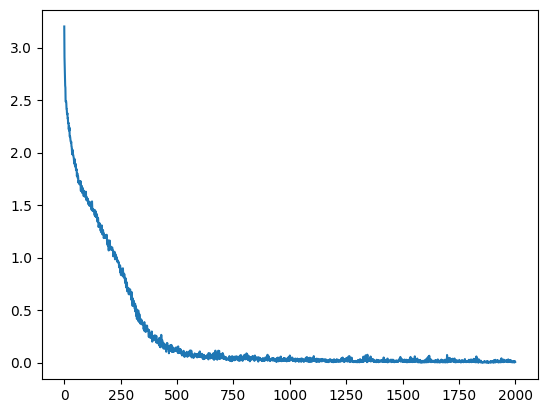

In [ ]:
plt.plot(losses)

In [ ]:
def greedy_decoding(model, src, context_size):
    # targ = torch.zeros(1,context_size + 1).type(torch.int)
    # targ = torch.zeros(1,src.shape[1] + 1).type(torch.int)
    cur_targ = torch.tensor([[0]])
    src_mask, _ = create_mask(src, src, 99)
    features = model.encode(src, src_mask)
    print(features.shape)
    for i in range(context_size):
        src_mask, targ_mask = create_mask(src, cur_targ, 99)
        proj = model.decode(cur_targ, features, src_mask, targ_mask)
        tok = torch.argmax(proj[0,-1,:], keepdims=True)
        # print(tok.shape)
        tok = tok.unsqueeze(0)
        if tok.item() == 1:
            return cur_targ[:,1:], proj
        cur_targ = torch.cat([cur_targ, tok], dim=1).type(torch.int)
        # targ[0, i+1] = tok
    return cur_targ, proj

cur_src = torch.randint(2, 12, size=(1, 10))
print(cur_src.shape)

cur_targ, proj = greedy_decoding(model, cur_src, 20)
print(cur_src)
print(cur_targ)
assert torch.equal(cur_src, cur_targ)
# print(proj)

torch.Size([1, 10])
torch.Size([1, 10, 32])
tensor([[ 4,  3,  5,  6, 11,  6,  5,  6,  5, 10]])
tensor([[ 4,  3,  5,  6, 11,  6,  5,  6,  5, 10]], dtype=torch.int32)


In [ ]:
# ans = torch.max(proj[0,0],0)
# ans
torch.zeros((1,1)).type(torch.int)

tensor([[0]], dtype=torch.int32)

# test training on real data

In [6]:
# !pip uninstall --yes portalocker
# !pip install portalocker
# !pip uninstall --yes torchtext
# !pip install torchtext==0.15.2
# import portalocker
import torchtext.datasets
from torch.utils.data import DataLoader

train_data = torchtext.datasets.Multi30k(split='train', language_pair=('de', 'en'))
val_data = torchtext.datasets.Multi30k(split='valid', language_pair=('de', 'en'))
test_data = torchtext.datasets.Multi30k(split='test', language_pair=('de', 'en'))

In [7]:
# ! rm -f /root/.cache/torch/text/datasets/Multi30k/val.de
# torchtext.__version__

In [8]:
# !pip uninstall --yes spacy
!pip install -U spacy
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm
import en_core_web_sm
import de_core_news_sm

en_tokenizer = en_core_web_sm.load()
de_tokenizer = de_core_news_sm.load()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.
2023-12-31 23:06:12.416834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 23:06:12.416897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Att

In [9]:
from collections import Counter

def get_unique_tokens(text, tokenizer, min_freq):
    cnt = Counter()
    for doc in tokenizer.pipe(text):
        doc_tokens = [tok.text.strip().lower() for tok in doc if len(tok.text) > 0]
        cnt.update(doc_tokens)
    return [tok for tok, freq in cnt.most_common() if freq >= min_freq]

src_text, targ_text = list(zip(*train_data))

min_freq = 2

de_toks = get_unique_tokens(src_text, de_tokenizer, min_freq)
en_toks = get_unique_tokens(targ_text, en_tokenizer, min_freq)
print(f"{len(de_toks)=} {len(en_toks)=}")


len(de_toks)=7848 len(en_toks)=5889


In [10]:
# special token indices
UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

UNK = '<unk>' # Unknown
PAD = '<pad>' # Padding
SOS = '<sos>' # Start of sentence
EOS = '<eos>' # End of sentence

SPECIAL_TOKENS = [UNK, PAD, SOS, EOS]

class Vocab:
    def __init__(self, tokenizer, tokens):
        self.tokenizer = tokenizer
        self.tokens = SPECIAL_TOKENS + tokens
        self.token_idxs = {self.tokens[i]: i for i in range(len(self.tokens))}

    def __call__(self, text):
        return [self.numerify(tok.text.strip().lower()) for tok in self.tokenizer(text)]

    def numerify(self, tok):
        if tok not in self.token_idxs:
            return UNK_IDX
        return self.token_idxs[tok]

    def textify(self, idx):
        return self.tokens[idx]

    def to_string(self, idxs):
        for i in range(idxs.shape[0]):
            return " ".join([self.textify(idx) for idx in idxs[i]])

de_vocab = Vocab(de_tokenizer, de_toks)
en_vocab = Vocab(en_tokenizer, en_toks)

In [11]:
from torch.nn.utils.rnn import pad_sequence
import random

def make_dataloader(dataset, batch_size, context_size, device):
    def sort_by_length(bucket):
      return sorted(bucket, key= lambda x: len(x[0]))

    # dataset = dataset.bucketbatch(batch_size=batch_size, sort_key=sort_by_length, bucket_num=1)

    def collate_fn(batch):
        srcs = []
        targs = []

        for i, (src_sentence, targ_sentence) in enumerate(batch):
            if len(src_sentence) == 0 or len(targ_sentence) == 0:
              continue
            src = [SOS_IDX] + de_vocab(src_sentence) + [EOS_IDX]
            targ = [SOS_IDX] + en_vocab(targ_sentence) + [EOS_IDX]

            srcs.append(torch.tensor(src))
            targs.append(torch.tensor(targ))

        src_batch = pad_sequence(srcs, padding_value=PAD_IDX, batch_first=True)
        targ_batch = pad_sequence(targs, padding_value=PAD_IDX, batch_first=True)

        # src_batch = torch.cat((src_batch, torch.full((src_batch.shape[0], 1), PAD_IDX)), axis=-1)
        # targ_batch = torch.cat((targ_batch, torch.full((src_batch.shape[0], 1), PAD_IDX)), axis=-1)

        # decoder wants target starting with SOS
        target_batch = targ_batch[:, :-1]
        # however when calculating loss we are only interested in tokens after SOS and ending with EOS
        label_batch = targ_batch[:, 1:]
        src_mask, targ_mask = create_mask(src_batch, target_batch, PAD_IDX) # TODO: understand what the hell happens with different context lengths

        all_batches = [src_batch, target_batch, label_batch, src_mask, targ_mask]
        return [b.to(device, dtype=torch.long) for b in all_batches]

    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)


device= 'cuda' if torch.cuda.is_available() else 'cpu'
# device="cpu"


train_dataloader = make_dataloader(train_data, 128, 100, device)
val_dataloader = make_dataloader(val_data, 128, 100, device)
# test_dataloader = make_dataloader(test_data, 100, 40, device)

In [12]:
import datetime
import numpy as np
from tqdm import tqdm

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# device = "cuda"


model = EncoderDecoderTransformer(
    n_heads=8, n_embed=256, dropout=0.1, n_blocks=3, ff_expansion_factor=2, context_size=100, input_vocab_size=len(de_vocab.tokens), output_vocab_size=len(en_vocab.tokens), pad_idx=PAD_IDX
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

# model = TestModel(d_model=256, n_heads=8, n_block=6, dropout=0.2, input_vocab_size=len(de_vocab.tokens), output_vocab_size=len(en_vocab.tokens), context_size=44+1).to(device)

# NONSENSE START ##

# INPUT_DIM = len(de_vocab.tokens)
# OUTPUT_DIM = len(en_vocab.tokens)
# HID_DIM = 256
# ENC_LAYERS = 3
# DEC_LAYERS = 3
# ENC_HEADS = 8
# DEC_HEADS = 8
# ENC_PF_DIM = 512
# DEC_PF_DIM = 512
# ENC_DROPOUT = 0.1
# DEC_DROPOUT = 0.1

# enc = Encoder(INPUT_DIM,
#               HID_DIM,
#               ENC_LAYERS,
#               ENC_HEADS,
#               ENC_PF_DIM,
#               ENC_DROPOUT,
#               device)

# dec = Decoder(OUTPUT_DIM,
#               HID_DIM,
#               DEC_LAYERS,
#               DEC_HEADS,
#               DEC_PF_DIM,
#               DEC_DROPOUT,
#               device)

# model = Seq2Seq(enc, dec, PAD_IDX, PAD_IDX, device).to(device)

model = model.apply(initialize_weights)

# model.load_state_dict(torch.load("inited-model.pt"))


# NONSENSE END ##

train_losses = []
val_losses = []

optim = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08)

for epoch in range(7):
    start_time = datetime.datetime.utcnow()

    train_loss = train(model, train_dataloader, criterion, optim)
    val_loss = evaluate(model, val_dataloader, criterion)

    # train_loss = train_test_model(model, train_dataloader, calculate_loss, optim, PAD_IDX)
    # val_loss = evaluate_test_model(model, val_dataloader, calculate_loss, PAD_IDX)

    end_time = datetime.datetime.utcnow()
    print(f"{train_loss=} {val_loss=} duration={end_time - start_time}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)


0batch [00:00, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
95batch [03:20,  2.11s/batch]


KeyboardInterrupt: ignored

In [ ]:
targ = torch.arange(99)
src = torch.arange(5, 100)
targ[-1] = PAD_IDX
src[-1] = PAD_IDX
targ = targ.unsqueeze(0)
src = src.unsqueeze(0)

src_mask, targ_mask = create_mask(src, targ, PAD_IDX)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model = EncoderDecoderTransformer(
    n_heads=8, n_embed=256, dropout=0.1, n_blocks=3, ff_expansion_factor=2, context_size=100, input_vocab_size=len(de_vocab.tokens), output_vocab_size=len(en_vocab.tokens), pad_idx=PAD_IDX
).to(device)

model.load_state_dict(torch.load("inited-model.pt"))
# model.apply(initialize_weights)
model.eval()
out = model(src.to(device), targ.to(device), src_mask.to(device), targ_mask.to(device))
print(out.type())
print(out[0, 80, 2])
# print(torch.randn((1, 3)))

In [ ]:
print(model.encoders[0].attention.wk.weight.data[30,3])


In [ ]:
torch.all(labels.view(logits.shape[0] * logits.shape[1]) == labels.contiguous().view(-1))
crit = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

t = logits.contiguous().view(logits.shape[0] * logits.shape[1], -1)
l = labels.contiguous().view(-1)

my_loss = F.cross_entropy(logits.view(logits.shape[0] * logits.shape[1], -1), labels.view(-1), ignore_index=PAD_IDX)
their_loss = crit(t, l)

my_loss == their_loss


# print(de_vocab.to_string(src[57].unsqueeze(0)))
# print(en_vocab.to_string(targ[57].unsqueeze(0)))
# print(src[57].shape, targ[57].shape)

# for i in range(src.shape[0]):
#   print(de_vocab.to_string(src[i].unsqueeze(0)))
#   print(en_vocab.to_string(targ[i].unsqueeze(0)))

In [ ]:
de_vocab.tokens

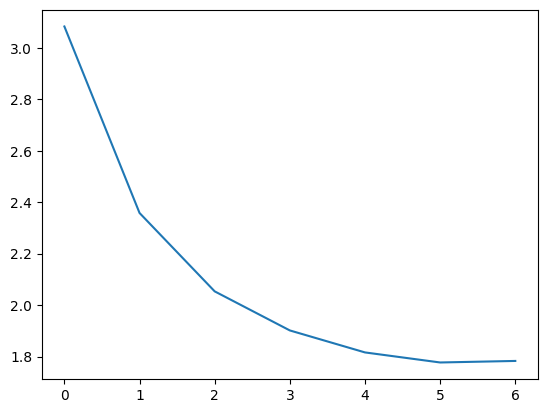

In [ ]:
import matplotlib.pyplot as plt

plt.plot(val_losses)

In [ ]:

idx = 127

cur_src = next(train_dataloader.__iter__())[0][idx]
cur_targ = next(train_dataloader.__iter__())[1][idx]
cur_label = next(train_dataloader.__iter__())[2][idx]
print(cur_src.shape)

# cur_targ = greedy_decoding(model, cur_src.unsqueeze(0), 44, SOS_IDX, PAD_IDX)
print(f"{cur_src.shape=} {cur_targ.shape=}")
print(f"{cur_src=}")
print(f"{cur_targ=}")
print(f"{cur_label=}")
print(f"{de_vocab.to_string(cur_src.unsqueeze(0))=}")
print(f"{en_vocab.to_string(cur_targ.unsqueeze(0))=}")
print(f"{en_vocab.to_string(cur_label.unsqueeze(0))=}")


torch.Size([9])
cur_src.shape=torch.Size([9]) cur_targ.shape=torch.Size([11])
cur_src=tensor([   2,    5,   13, 1763,    7,    6,  296,    4,    3], device='cuda:0')
cur_targ=tensor([   2,    4,    9,   10, 1643,    6,    4,  309,    5,    3,    1],
       device='cuda:0')
cur_label=tensor([   4,    9,   10, 1643,    6,    4,  309,    5,    3,    1,    1],
       device='cuda:0')
de_vocab.to_string(cur_src.unsqueeze(0))='<sos> ein mann watet in einem fluss . <eos>'
en_vocab.to_string(cur_targ.unsqueeze(0))='<sos> a man is wading in a river . <eos> <pad>'
en_vocab.to_string(cur_label.unsqueeze(0))='a man is wading in a river . <eos> <pad> <pad>'


In [ ]:
cnt = 0
train_iter = iter(val_dataloader)
for src, targ, label, src_mask, targ_mask in train_iter:
  cnt += src.shape[0]
  print(cnt)

print(cnt)

99
199
299
399
499
599
699
799
899
999
1014
1014


In [ ]:
for src, targ, labels, src_mask, targ_mask in train_dataloader:
  print(de_vocab.to_string(src[1].unsqueeze(0)))
  print(en_vocab.to_string(labels[1].unsqueeze(0)))
  # print(src_mask[1])
  # print(targ_mask[1])
  src_mask, targ_mask = create_mask(src[1].unsqueeze(0).to("cpu"), targ[1].unsqueeze(0).to("cpu"), PAD_IDX)
  break

print(src[1])
print(src_mask)
print("trans", de_vocab.to_string(torch.tensor([[4]])))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Several men in hard hats are operating a giant pulley system . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
tensor([  84,   31,   10,  837, 2095,   15, 8013,    4,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1], device='cuda:0')
tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False]]]])
trans .


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 9,038,085 trainable parameters


In [ ]:
# bleu

calculate_bleu(model, val_dataloader, 100, SOS_IDX, PAD_IDX, EOS_IDX, en_vocab)

# calculate_test_bleu(model, val_dataloader, 44, SOS_IDX, PAD_IDX, EOS_IDX, en_vocab)

0batch [00:00, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
8batch [00:20,  2.53s/batch]


[['a', 'group', 'of', 'men', '<unk>', 'a', 'truck', 'at', 'a', 'truck', '.'], ['a', 'man', 'is', 'sleeping', 'on', 'a', 'couch', 'in', 'a', 'green', 'room', '.'], ['a', 'young', 'boy', 'with', 'headphones', 'on', 'on', 'top', 'of', 'a', 'woman', "'s", 'shoulders', '.'], ['two', 'men', 'building', 'a', '<unk>', 'on', 'a', 'lake', '.'], ['a', 'balding', 'man', 'wearing', 'a', 'red', 'life', 'jacket', 'sits', 'in', 'a', 'small', 'boat', '.'], ['a', 'woman', 'in', 'a', 'red', 'coat', ',', 'holding', 'a', '<unk>', '<unk>', '<unk>', 'for', 'a', 'book', 'to', 'an', 'asia', 'in', 'an', 'asia', '.'], ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.'], ['a', 'little', 'boy', 'with', 'a', 'baseball', 'bat', ',', 'swings', 'a', 'baseball', 'bat', 'for', 'a', 'ball', 'on', 'a', 'ball', '.'], ['a', 'man', 'is', 'talking', 'on', 'a', 'messy', 'office', 'at', 'an', 'office', 'office', 'office', '.'], ['a', 'smiling', 'woman', 'with', 'a', 'peach', 'top', 'holds', 'a', 'luggage', '.'], 

0.33534646030279575

In [72]:
import matplotlib.pyplot as plt
from matplotlib import ticker

def visualise_attention(attention_matrix, src_sentence, targ_sentence):
  attention_matrix = attention_matrix.cpu().detach()
  n_heads = attention_matrix.shape[1]
  fig, axs = plt.subplots(2, 4, figsize=(25, 15))
  for i, ax in enumerate(axs.flat):
     ax.tick_params(labelsize=12)
     ax.matshow(attention_matrix[0, i, :,:])
     ax.set_yticklabels(src_sentence)
     ax.set_xticklabels(targ_sentence)
     ax.label_outer()
     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


idx = 0

idata = iter(train_dataloader)

for _ in range(1):
  data = next(idata)

src = data[0][idx]
targ = data[1][idx]
src_mask = data[3][idx]
targ_mask = data[4][idx]
attn = model.decoders[2].masked_attention.store



In [73]:
pred = greedy_decoding(model, src.unsqueeze(0), src.shape[0], SOS_IDX, PAD_IDX)


['<sos>', 'two', 'men', 'are', 'are', 'playing', 'the', 'street', '.']
['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


<ipython-input-72-0b48cbd60e82>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(src_sentence)
<ipython-input-72-0b48cbd60e82>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(targ_sentence)


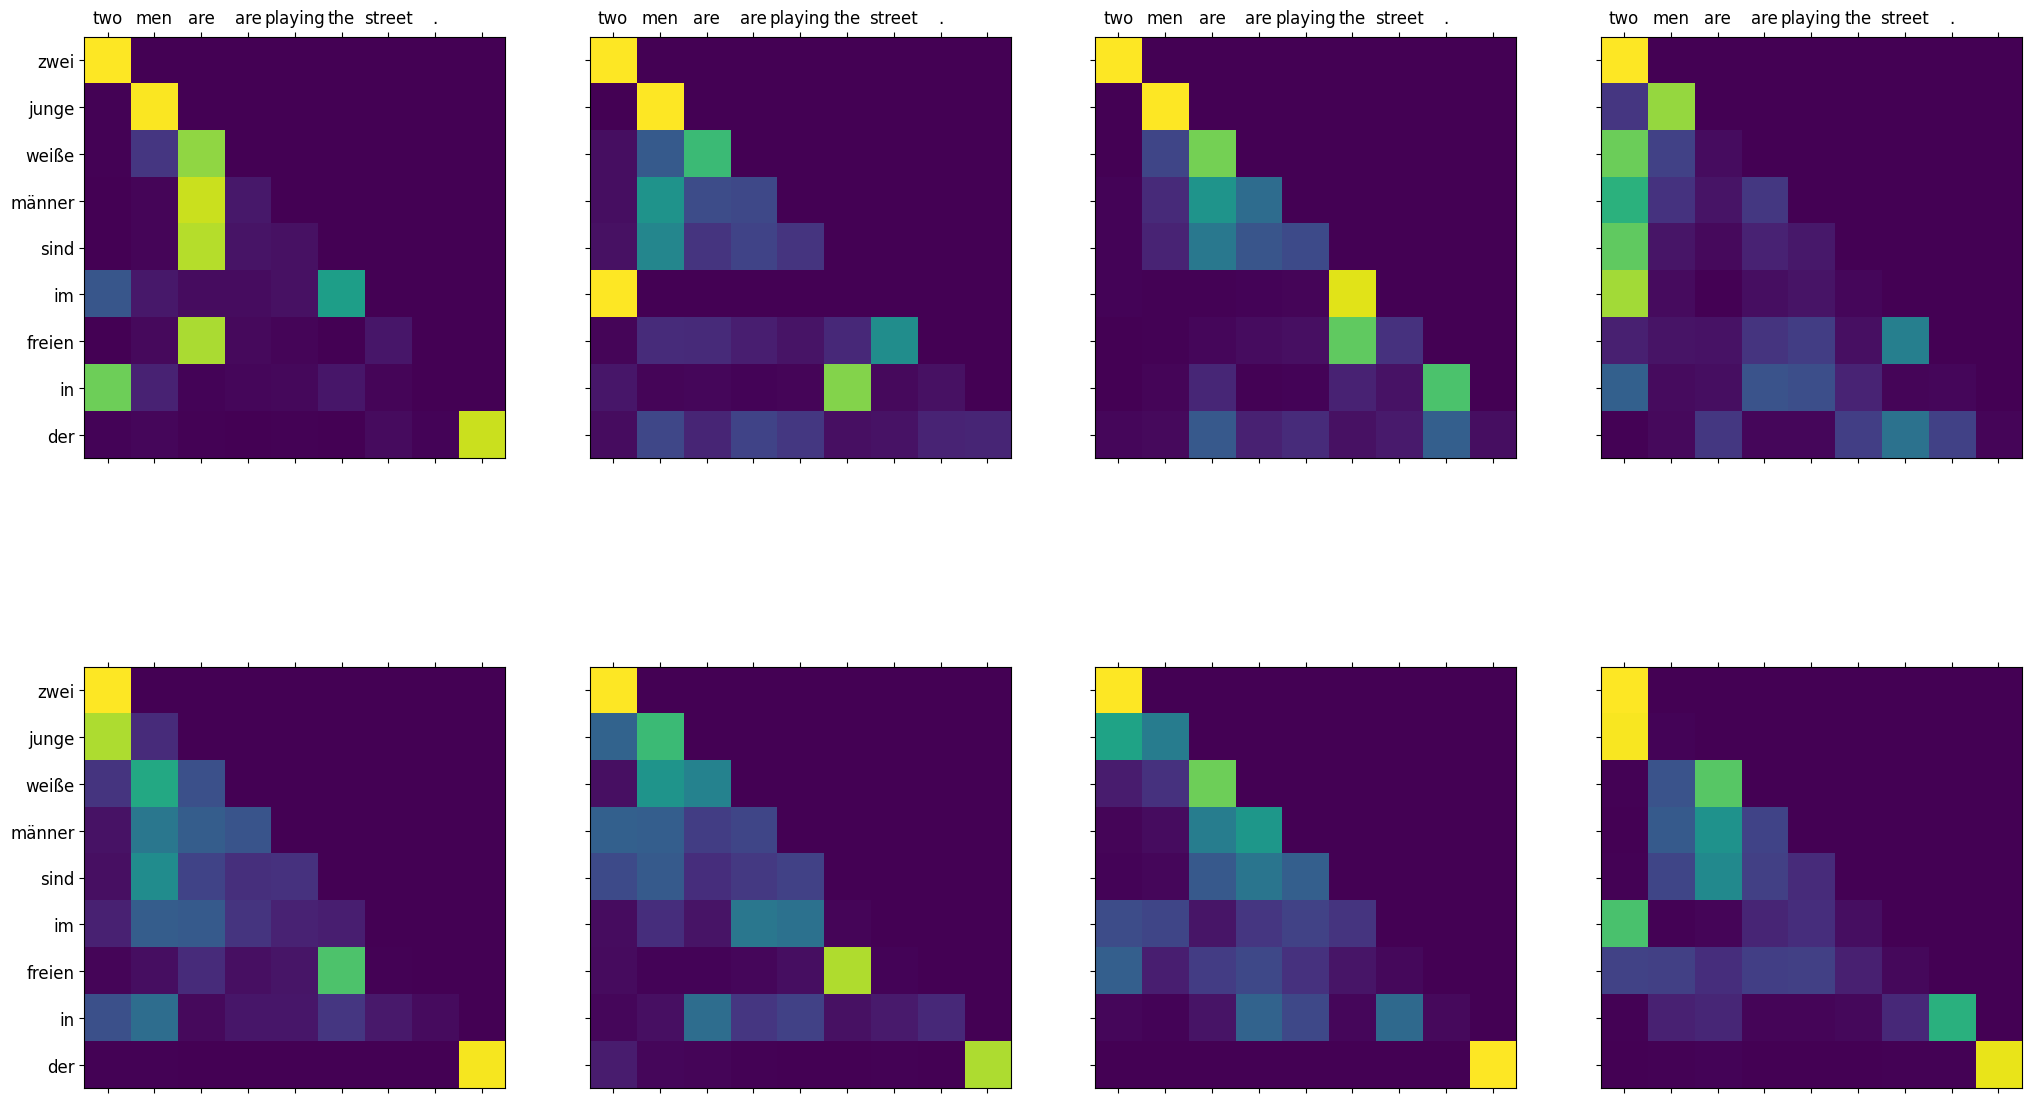

In [77]:
pad_idx = torch.argmax((src == 1).to(dtype=torch.int), dim=-1)
trunc_src = src[:pad_idx]

pred_trans = ["<sos>"] + [en_vocab.textify(tok) for tok in pred[0]]
src_trans = [de_vocab.textify(tok) for tok in src]
print(pred_trans)
print(src_trans)

visualise_attention(model.decoders[1].masked_attention.store,src_trans, pred_trans)

In [84]:
model.decoders[0].masked_attention.store.shape


torch.Size([1, 8, 9, 9])

## prove i'm not going mad

In [75]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src scalelen, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

    def encode(self, src, src_mask):
      return self.encoder(src, src_mask)

    def decode(self, features, trg, src_mask):
      trg_mask = self.make_trg_mask(trg)
      output, _ = self.decoder(trg, features, trg_mask, src_mask)
      return output

class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src


class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]

        return src

In [ ]:
def translate_sentence_vectorized(src_tensor, targ_vocab, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[SOS_IDX] for _ in range(len(src_tensor))]

    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i in [EOS_IDX, PAD_IDX]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] in [EOS_IDX, PAD_IDX]:
                break
            pred_sentence.append(targ_vocab.textify(trg_sentence[i]))
        pred_sentences.append(pred_sentence)

    return pred_sentences

In [ ]:
translate_sentence_vectorized(next(iter(val_dataloader))[0][7].unsqueeze(0), en_vocab, model, device, max_len=45)

[['a', 'band', 'plays', 'on', 'the', 'sidewalk', '.']]

In [ ]:
print(en_vocab.to_string(next(iter(val_dataloader))[2][7].unsqueeze(0)))
print(de_vocab.to_string(next(iter(val_dataloader))[0][7].unsqueeze(0)))

a band playing on a sidewalk . <eos> <pad> <pad> <pad> <pad> <pad> <pad>
eine band spielt auf dem gehweg . <eos> <pad> <pad> <pad> <pad>


# use not mad

In [ ]:
## check attention is same

mal = MultiHeadAttentionLayer(256, 8, 0, "cpu")
ma = MultiHeadAttention(8, 256, 0)

In [ ]:
print(mal)
print(ma)

MultiHeadAttentionLayer(
  (fc_q): Linear(in_features=256, out_features=256, bias=True)
  (fc_k): Linear(in_features=256, out_features=256, bias=True)
  (fc_v): Linear(in_features=256, out_features=256, bias=True)
  (fc_o): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)
MultiHeadAttention(
  (wk): Linear(in_features=256, out_features=256, bias=True)
  (wq): Linear(in_features=256, out_features=256, bias=True)
  (wv): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (proj): Linear(in_features=256, out_features=256, bias=True)
)


In [ ]:
mal.fc_q.weight = ma.wq.weight
mal.fc_k.weight = ma.wk.weight
mal.fc_v.weight = ma.wv.weight
mal.fc_o.weight = ma.proj.weight

mal.fc_q.bias = ma.wq.bias
mal.fc_k.bias = ma.wk.bias
mal.fc_v.bias = ma.wv.bias
mal.fc_o.bias = ma.proj.bias



In [ ]:
def clone_atten_layer(l1, l2):
  l1.fc_q.weight = l2.wq.weight
  l1.fc_k.weight = l2.wk.weight
  l1.fc_v.weight = l2.wv.weight
  l1.fc_o.weight = l2.proj.weight

  l1.fc_q.bias = l2.wq.bias
  l1.fc_k.bias = l2.wk.bias
  l1.fc_v.bias = l2.wv.bias
  l1.fc_o.bias = l2.proj.bias

def clone_encoder_block(b1, b2):
  clone_atten_layer(b1.self_attention, b2.attention)

  b1.positionwise_feedforward.fc_1.weight.data = b2.ffw.ffw[0].weight.data
  b1.positionwise_feedforward.fc_1.bias.data = b2.ffw.ffw[0].bias.data
  b1.positionwise_feedforward.fc_2.weight.data = b2.ffw.ffw[3].weight.data
  b1.positionwise_feedforward.fc_2.bias.data = b2.ffw.ffw[3].bias.data

def clone_decoder_block(b1, b2):
  clone_atten_layer(b1.self_attention, b2.masked_attention)
  clone_atten_layer(b1.encoder_attention, b2.cross_attention)

  b1.positionwise_feedforward.fc_1.weight.data = b2.ffw.ffw[0].weight.data
  b1.positionwise_feedforward.fc_1.bias.data = b2.ffw.ffw[0].bias.data
  b1.positionwise_feedforward.fc_2.weight.data = b2.ffw.ffw[3].weight.data
  b1.positionwise_feedforward.fc_2.bias.data = b2.ffw.ffw[3].bias.data

def clone_embedding(e1, e2):
  e1.weight.data = e2.weight.data
  # e1.bias.data = e2.bias.data



In [ ]:
t = torch.randn((5, 10, 256))

print(t.shape)

# src_mask = torch.tril(torch.ones((10, 10), device = "cpu")).bool()
src_mask = torch.ones_like(t[0,:,1]).unsqueeze(0)
src_mask[0,-1] = 0

print(src_mask.shape)

o1 = mal(t, t, t, src_mask)
o2 = ma(t, t, src_mask)

torch.Size([5, 10, 256])
torch.Size([1, 10])


In [ ]:
torch.all(o1[0] == o2)

tensor(True)

In [ ]:
## check masks are the same

src = torch.tensor([
  [1, 2, 3, 4, PAD_IDX, PAD_IDX],
  [2, 8, 0, 9, 4, PAD_IDX]
]).to("cuda")

sm1 = model.make_src_mask(src)
tm1 = model.make_trg_mask(src)

sm2,tm2 = create_mask(src.to("cpu"), src.to("cpu"), PAD_IDX)

print(tm1.shape, tm2.shape)

assert torch.all(sm1.to("cpu") == sm2)
assert torch.all(tm1.to("cpu") == tm2)

torch.Size([2, 1, 6, 6]) torch.Size([2, 1, 6, 6])


In [ ]:
## compare encoder layer

torch.manual_seed(134)

def initer(p):
  if hasattr(p, 'weight') and p.weight.dim() > 1:
    nn.init.constant_(p.weight.data, 0.2)
  if hasattr(p, 'bias'):
    nn.init.constant_(p.bias.data, 0.2)

def normal_initer(p):
    if hasattr(p, 'weight') and p.weight.dim() > 1:
      torch.nn.init.uniform_(p.weight.data, 0.2)
    if hasattr(p, 'bias'):
      torch.nn.init.uniform_(p.bias.data, 0.2)

tenc1 = EncoderLayer(64, 8, 128, 0, "cuda").to("cuda")
tenc2 = EncoderBlock(8, 64, 2, 0).to("cuda")

tenc1 = tenc1.apply(initer)
tenc2 = tenc2.apply(initer)

src = torch.randn((100, 4, 64))
fake_src = torch.zeros((100, 4))
fake_src[0][-1] == PAD_IDX
src_mask = model.make_src_mask(fake_src)
targ_mask = model.make_trg_mask(fake_src.to("cuda"))
# src_mask[0][-1] = False

o1 = tenc1.forward(src.to("cuda"), src_mask.to("cuda"))
o2 = tenc2.forward((src.to("cuda"), src_mask.to('cuda')))[0]

torch.all(o1 == o2)

tensor(False, device='cuda:0')

In [ ]:
## check decoder block is the same

tdec1 = DecoderLayer(64, 8, 128, 0, "cuda").to("cuda")
tdec2 = DecoderBlock(8, 64, 2, 0).to("cuda")

# tdec1 = tdec1.apply(normal_initer)
# tdec2 = tdec2.apply(normal_initer)

clone_atten_layer(tdec1.self_attention, tdec2.masked_attention)
clone_atten_layer(tdec1.encoder_attention, tdec2.cross_attention)

tdec1.positionwise_feedforward.fc_1.weight.data = tdec2.ffw.ffw[0].weight.data
tdec1.positionwise_feedforward.fc_1.bias.data = tdec2.ffw.ffw[0].bias.data
tdec1.positionwise_feedforward.fc_2.weight.data = tdec2.ffw.ffw[3].weight.data
tdec1.positionwise_feedforward.fc_2.bias.data = tdec2.ffw.ffw[3].bias.data


targ = torch.randn((100, 4, 64))

o1 = tdec1.forward(targ.to("cuda"), src.to("cuda"), targ_mask.to("cuda"), src_mask.to("cuda"))[0]
print("#######")
o2 = tdec2.forward((targ.to("cuda"), src.to("cuda"), src_mask.to('cuda'), targ_mask.to("cuda")))[0]

torch.all(torch.isclose(o1, o2))

pre all tensor(1.3986, device='cuda:0')
pre ma ln tensor(-0.1222, device='cuda:0', grad_fn=<SelectBackward0>)
post masked atten tensor(1.2645, device='cuda:0', grad_fn=<SelectBackward0>)
post cross atten tensor(1.2966, device='cuda:0', grad_fn=<SelectBackward0>)
post ffw tensor(1.3194, device='cuda:0', grad_fn=<SelectBackward0>)
#######
pre all tensor(1.3986, device='cuda:0')
pre ma ln tensor(-0.1222, device='cuda:0', grad_fn=<SelectBackward0>)
post masked atten tensor(1.2645, device='cuda:0', grad_fn=<SelectBackward0>)
post cross atten tensor(1.2966, device='cuda:0', grad_fn=<SelectBackward0>)
post ffw tensor(1.3194, device='cuda:0', grad_fn=<SelectBackward0>)


tensor(False, device='cuda:0')

In [ ]:
diff = o1-o2
diff[~torch.isclose(o1, o2)]

tensor([-9.5926e-08,  1.7288e-08, -6.4727e-08, -4.1677e-08, -6.0289e-08,
         4.4005e-08, -5.1456e-08,  2.1659e-08, -1.4828e-08,  2.2119e-08,
         1.1548e-07,  7.4273e-08,  1.0966e-07, -2.6077e-08,  5.4482e-08,
        -7.2876e-08, -2.8522e-08, -6.2748e-08,  5.2154e-08,  1.5600e-07,
        -3.7835e-08,  1.4057e-08, -5.8208e-08, -6.4203e-08, -4.0978e-08,
         5.2620e-08, -2.1537e-08, -4.1910e-08, -2.2817e-08, -1.0338e-07,
        -1.2503e-07, -5.3085e-08, -9.3598e-08, -9.2201e-08,  4.9593e-08,
         4.4703e-08, -3.1205e-08, -5.4903e-08, -3.6322e-08,  1.2666e-07,
        -1.1828e-07], device='cuda:0', grad_fn=<IndexBackward0>)

In [ ]:
# conclusion re decoder block is not at all clear - are the differences within tolerance for numerical nonsense - I think probably yes?

# o1[~torch.isclose(o1, o2)] - o2[~torch.isclose(o1, o2)]
torch.sum(torch.abs(o1[0] - o2))

tensor(340.7946, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
# full model

tenc = Encoder(100,
              64,
              3,
              8,
              128,
              0,
              device)

tdec = Decoder(100,
              64,
              3,
              8,
              128,
              0,
              device)

tmod1 = Seq2Seq(tenc, tdec, PAD_IDX, PAD_IDX, device).to(device)
tmod2 = EncoderDecoderTransformer(8, 64, 0, 3, 2, 40, 100, 100, PAD_IDX).to(device)

tmod2 = tmod2.apply(initialize_weights)

for b1, b2 in zip(tenc.layers, tmod2.encoders):
  clone_encoder_block(b1, b2)

for b1, b2 in zip(tdec.layers, tmod2.decoders):
  clone_decoder_block(b1, b2)

clone_embedding(tenc.tok_embedding, tmod2.src_embedding)
clone_embedding(tenc.pos_embedding, tmod2.src_positional_embedding.posem)
clone_embedding(tdec.tok_embedding, tmod2.targ_embedding)
clone_embedding(tdec.pos_embedding, tmod2.targ_positional_embedding.posem)

tdec.fc_out.weight.data = tmod2.output.proj.weight.data
tdec.fc_out.bias.data = tmod2.output.proj.bias.data

fake_src = torch.randint(2, 99, (128, 30))
fake_src[0][-1] == PAD_IDX
fake_targ = torch.randint(2, 99, (128, 30))
fake_targ[0][-1] == PAD_IDX
fake_targ[0][-2] == PAD_IDX
src_mask = tmod1.make_src_mask(fake_src)
targ_mask = tmod1.make_trg_mask(fake_targ.to("cuda"))

r_src_mask, r_targ_mask = create_mask(fake_src, fake_targ, PAD_IDX)

o1 = tmod1.forward(fake_src.to("cuda"), fake_targ.to("cuda"))
o2 = tmod2.forward(fake_src.to("cuda"), fake_targ.to("cuda"), r_src_mask.to("cuda"), r_targ_mask.to("cuda"))

In [ ]:
diff = o1[0] - o2
torch.all(torch.isclose(o1[0], o2))

diff[~torch.isclose(o1[0], o2)]


tensor([-4.0233e-07,  5.0664e-07,  6.5565e-07,  ...,  3.5763e-07,
         1.7881e-07, -1.7881e-07], device='cuda:0', grad_fn=<IndexBackward0>)

In [ ]:
o2[0][0]

tensor([26.4329, 26.6894, 26.6778, 24.2886, 21.4581, 26.0428, 23.0472, 24.7406,
        25.8354, 24.6435, 24.8914, 22.2514, 24.5238, 22.4105, 23.4937, 26.4942,
        21.1475, 20.9434, 22.7235, 22.0529, 25.5978, 28.3934, 24.6118, 21.2918,
        25.4201, 21.4672, 24.5572, 22.9458, 21.8525, 22.6120, 26.0886, 25.4559,
        20.7239, 22.4887, 21.8177, 23.7655, 23.5163, 20.4651, 24.1686, 21.7318,
        25.6679, 25.4506, 23.7346, 21.8858, 23.4769, 22.6967, 21.2442, 24.6870,
        29.0173, 22.2686, 22.1076, 27.5821, 22.2713, 23.4479, 25.0203, 22.1267,
        22.0710, 24.6205, 23.2300, 23.2619, 25.0301, 30.2481, 23.2352, 27.1517,
        24.4211, 27.0556, 23.4845, 24.6067, 29.5664, 25.4720, 25.1050, 28.3486,
        22.0874, 25.3098, 23.0661, 20.4149, 23.3791, 24.7078, 23.0772, 22.5729,
        25.7082, 25.7629, 21.4084, 23.0432, 22.4774, 24.8612, 22.5446, 21.5128,
        19.6772, 21.7822, 22.6107, 24.3128, 23.9185, 26.6269, 22.9730, 21.4747,
        26.7504, 19.9236, 22.7232, 26.03

In [ ]:
o1[0][0].shape

torch.Size([4, 100])

In [ ]:
o1[0][0] - o2[0][0]

tensor([[-1.7402, -3.7163, -4.5737,  1.5954,  1.8731, -2.1012, -0.8862, -1.4852,
         -6.0744, -3.1907, -1.7264,  2.6252, -2.2538, -5.7633, -3.6445, -1.1890,
          2.6793,  3.7957, -0.3157,  5.5326, -4.9832, -4.0124, -1.5378,  3.0071,
         -0.5574, -1.0221,  2.1690, -1.3486,  2.4848,  4.4794, -2.1753, -1.1468,
          4.7861,  0.9414,  2.2245, -1.3365,  1.6891,  3.5329, -2.0749,  1.6166,
          2.1101, -4.0841, -2.5732,  3.5365, -2.1776, -3.0156,  4.6261, -0.6019,
         -2.5304,  0.9072,  0.2988, -2.5588, -0.7409,  1.3781, -2.0704,  0.5592,
         -1.7714, -2.2864,  1.8366,  0.3351,  2.2533, -6.8041, -1.0382, -0.7151,
         -1.0143, -4.0375,  4.2660, -1.5216, -4.9166,  2.4342, -0.0249, -5.7164,
          1.3175, -6.8394,  3.7306,  1.2873, -3.1299, -6.9664,  0.1020,  1.2810,
         -2.2256, -1.9578,  2.9117,  3.8423,  0.7116, -3.3662,  0.3394,  3.5497,
          3.4377,  0.1838, -0.2078,  0.0868,  0.6595, -2.6310,  3.3161, -0.3036,
         -2.0693,  4.5677, -

NameError: ignored

In [8]:
import matplotlib.pyplot as plt

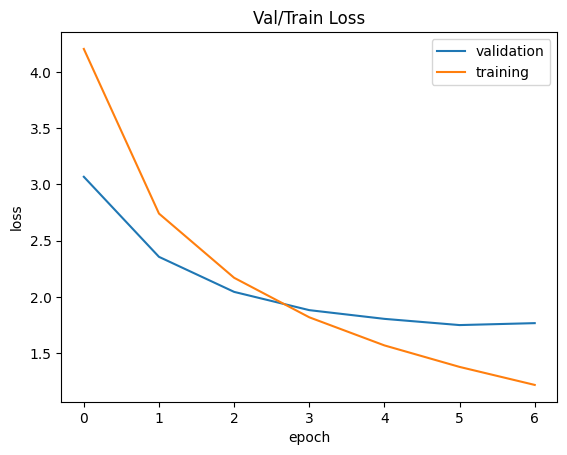

In [13]:
val_losses = [3.0685756504535675, 2.3569158017635345, 2.0454186350107193, 1.8830835670232773, 1.8055425435304642, 1.7503346055746078, 1.7675475031137466]
train_losses = [4.205121267209494, 2.7414815362854674, 2.1707053819942055, 1.8194913139427287, 1.5695837289751364, 1.378445950373679, 1.2183551428601604]

plt.plot(val_losses, label="validation")
plt.plot(train_losses, label="training")
plt.legend()
plt.title("Val/Train Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [ ]:
train_loss=4.205121267209494 val_loss=3.0685756504535675 duration=0:06:20.220338
beginning epoch {epoch}
227batch [06:23,  1.69s/batch]
8batch [00:13,  1.64s/batch]
train_loss=2.7414815362854674 val_loss=2.3569158017635345 duration=0:06:36.974030
beginning epoch {epoch}
227batch [06:15,  1.65s/batch]
8batch [00:13,  1.65s/batch]
train_loss=2.1707053819942055 val_loss=2.0454186350107193 duration=0:06:28.457374
beginning epoch {epoch}
227batch [06:11,  1.64s/batch]     8batch [00:12,  1.57s/batch]                                                                                               train_loss=1.8194913139427287 val_loss=1.8830835670232773 duration=0:06:24.397907
beginning epoch {epoch}
227batch [06:07,  1.62s/batch]
8batch [00:12,  1.57s/batch]                                train_loss=1.5695837289751364 val_loss=1.8055425435304642 duration=0:06:20.105865
beginning epoch {epoch}
227batch [06:10,  1.63s/batch]                                                                                             8batch [00:12,  1.60s/batch]
train_loss=1.378445950373679 val_loss=1.7503346055746078 duration=0:06:22.830278
beginning epoch {epoch}                                                                                                    227batch [06:09,  1.63s/batch]
8batch [00:12,  1.54s/batch]
train_loss=1.2183551428601604 val_loss=1.7675475031137466 duration=0:06:21.486282                                          8batch [00:18,  2.32s/batch]